**Tecnológico de Monterrey**

**Maestría en Inteligencia Artificial Aplicada**

**ASIGNATURA: Proyecto Integrador**

**PROFESOR TITULAR: Dra. Grettel Barceló Alonso**

**ACTIVIDAD:Avance 3. Baseline**

---
**EQUIPO 3**

*   Rayan Bahrein García Fabián - A01204055
*   Brandon Alexis del Ángel Gómez - A01795429
*   Fernando Jiménez Pereyra - A01734609

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import os
# DIR = "/content/drive/MyDrive/Poyecto/Datos"
# os.chdir(DIR)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from datetime import datetime
from scipy.stats import zscore
import ast
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.feature_selection import f_classif

from sklearn.model_selection import learning_curve

import joblib


In [ ]:
def save_models(model_dict, folder_name):
    # Crear la carpeta si no existe
    os.makedirs(folder_name, exist_ok=True)

    # Recorrer el diccionario y guardar cada modelo
    for key, model in model_dict.items():
        file_path = os.path.join(folder_name, f"{key}.joblib")
        joblib.dump(model, file_path)
        print(f"Guardado: {file_path}")

# Resumen

## 1) Justificación del algoritmo seleccionado

Para abordar el problema de predicción de desempeño (contribution_score) se optó por un enfoque supervisado utilizando modelos tanto de regresión (para el score continuo) como de clasificación (para niveles categóricos Bajo–Medio–Alto y binarios Alto vs No Alto).

Los modelos seleccionados fueron:

* Linear Regression: por su interpretabilidad y como línea base simple.
* RandomForest y XGBoost: por su capacidad para capturar relaciones no lineales, manejar interacciones entre variables y ser robustos ante multicolinealidad y outliers.
* Logistic Regression (binaria/multiclase): como benchmark lineal para tareas de clasificación.

La elección de estos algoritmos es adecuada considerando:

* Los datos son estructurados (tabulares).
* Se han realizado tareas extensas de transformación y codificación.
* Se dispone de suficientes registros para entrenar modelos complejos como XGBoost (~31 mil).
* La interpretabilidad es importante, pero también se desea obtener alto desempeño predictivo.


## 2) Relevancia de características

Se aplicaron diferentes estrategias para validar la relevancia de variables:

* Selección automática: se utilizaron solo variables escaladas o dummies relevantes (_scaled y category_).
* Codificación explícita: se transformaron variables categóricas con OneHotEncoder y se escalaron otras con StandardScaler y MinMaxScaler.
* SMOTE se utilizó en clasificación binaria para compensar el desbalance de clases (90% vs 10%).
* Análisis de correlación y PCA se realizaron en etapas anteriores para explorar colinealidades, descartándose n_skills_scaled por varianza cero.


## 3) Comparación de métricas para evaluar desempeño y sobreajuste

Para cada modelo se compararon métricas de entrenamiento y prueba como:

* MAE y R² (Regresión): permitieron observar mejoras al pasar del modelo lineal a RandomForest/XGBoost. El R² negativo en el primer experimento indicó un mal ajuste inicial, pero los modelos sobre datos depurados presentaron mejoras sustanciales (ej. R² ≈ 0.47).
* Accuracy, Recall, Precision, F1 (Clasificación): en multiclase y binaria se evidenció que:

  * LogisticRegression logra capturar la clase “Alto” en mayor proporción, aunque con menos precisión.
  * RandomForest y XGBoost tienden a favorecer la clase “No Alto”, incluso tras aplicar SMOTE.


## 4) Alineación de la métrica con el objetivo del negocio

Dado que el objetivo es apoyar la asignación óptima de recursos a proyectos, lo más crítico es identificar candidatos con alto potencial.

* En clasificación binaria, se prioriza recall y F1 para la clase "Alto", pues omitir un buen candidato es más costoso que incluir uno menos ideal.
* Se utilizó class_weight='balanced' y SMOTE para corregir el desbalance severo (90%/10%).


## 5) Evaluación de desempeño mínimo

Aunque no se dispone de un benchmark histórico definido, se estableció como meta superar las métricas obtenidas por los modelos baseline en un margen mínimamente significativo:

* MAE < 6.0 en regresión.
* R² > 0.25.
* F1-score aceptable (> 0.5) para la clase "Alto" en clasificación.

Con los datos depurados y enriquecidos:

* Se logró un MAE de 5.42 con RandomForest.
* En clasificación binaria, la F1 para "Alto" fue superior a 0.5 con LogisticRegression, mostrando potencial, aunque aún se puede mejorar.

Se considera se obtuvieron modelos con un desempeño inicial aceptable que sirven como punto de partida sólido para posteriores mejoras.

## 1. Primer anális de modelos base
### Carga de datos de etapas previas

In [ ]:
# Carga de datos ya transformados de etapas previas
empleados = pd.read_csv('empleados_final_V3.csv')
proyectos = pd.read_csv('proyectos_final_V3.csv')
asignaciones = pd.read_csv('asignaciones_final_V3.csv')
# El dataset que más nos interesa es df
df = pd.read_csv('dataset_modelo_baseline.csv')

In [ ]:
# Revisión rápida
print(df.shape)
df.head()

(31864, 67)


,assignment_id,project_id,employee_id,assigned_role,contribution_score,role,experience_years,experience_level,skills,availability,...,assigned_role_Sr. Network Engineer,n_skills,n_required_skills,experience_years_scaled,project_duration_scaled,skill_match_score_scaled,role_match_scaled,n_required_skills_scaled,experience_level_encoded_scaled,score_label
0,A0001,P0001,2418,Production Manager,73.6,Production Manager,2,Mid,"['Java', 'Redes', 'Aprendizaje Rápido']",No disponible,...,0.0,3,1,-1.213233,1.166096,0.462963,1.0,0.00,0.5,1
1,A0002,P0001,1021,Software Engineer,63.8,Software Engineer,4,Senior,"['Power BI', 'Java', 'Reclutamiento']",No disponible,...,0.0,3,1,0.198922,1.166096,0.462963,1.0,0.00,1.0,1
2,A0003,P0002,2228,IT Support,44.9,IT Support,6,Senior,"['Seguridad Informática', 'Python', 'Negociaci...",No disponible,...,0.0,3,4,1.611077,-0.466522,0.719807,1.0,0.75,1.0,0
3,A0004,P0002,1617,Production Technician I,44.2,Production Technician I,2,Mid,"['Calibración', 'Mantenimiento', 'Liderazgo']",Disponible,...,0.0,3,4,-1.213233,-0.466522,0.649758,1.0,0.75,0.5,0
4,A0005,P0002,2244,IT Manager - Support,49.1,Otro,2,Mid,"['Mantenimiento', 'Rutas de Distribución', 'Re...",Disponible,...,0.0,3,4,-1.213233,-0.466522,0.719807,0.0,0.75,0.5,0


### Selección de variables predictoras y variable objetivo

Notar que ya tenemos las siguientes variables

* `experience_years_scaled`
* `project_duration_scaled`
* `experience_level_encoded_scaled`
* `skill_match_score_scaled`
* `role_match_scaled`


In [ ]:
# Variable objetivo
target = "contribution_score"

# Selección automática de features escaladas y dummies
predictors = [col for col in df.columns if "_scaled" in col or col.startswith("category_")]

X = df[predictors]
y = df[target]


### División de datos

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


### Entrenamiento de modelos base

In [ ]:
modelos = {
    "baseline_reg_mean": DummyRegressor(strategy="mean"),
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBRegressor": XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\nModelo: {nombre}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")



Modelo: baseline_reg_mean
MAE: 8.0002
R²: -0.0000

Modelo: LinearRegression
MAE: 7.9741
R²: 0.0052

Modelo: RandomForestRegressor
MAE: 5.4247
R²: 0.4742

Modelo: XGBRegressor
MAE: 6.2650
R²: 0.3671


Las métricas MAE y R² son adecuadas:
* MAE permite interpretar en unidades del score cuánto se equivoca en promedio el modelo.
* R² nos da una medida relativa de cuánta variabilidad explica el modelo.
* Se busca que MAE sea bajo y R² positivo y cercano a 1.

Se plantea un umbral mínimo de desempeño razonable:
* MAE < 6 y R² > 0.25 como punto de referencia para considerar que el modelo ofrece valor frente a una predicción aleatoria.

In [ ]:
save_models(modelos, "modelos/Regresiones")

Guardado: modelos/Regresiones/baseline_reg_mean.joblib
Guardado: modelos/Regresiones/LinearRegression.joblib
Guardado: modelos/Regresiones/RandomForestRegressor.joblib
Guardado: modelos/Regresiones/XGBRegressor.joblib


## 2. Clasificación multiclase: Bajo, Medio y Alto

Modelo multiclase (predecir si el `contribution_score` es bajo, medio o alto).

### Crear variable objetivo

Creamos una variable objetivo `score_label_multiclass` para agrupar los valores continuos en 3 clase:

* Bajo: score < 65
* Medio: 65 ≤ score < 80
* Alto: score ≥ 80

In [ ]:
# Crear variable multiclase según rangos definidos
def clasificar_score(score):
    if score < 65:
        return "Bajo"
    elif score < 80:
        return "Medio"
    else:
        return "Alto"

# Aplicar la función al dataset
df["score_label_multiclass"] = df["contribution_score"].apply(clasificar_score)


<ipython-input-34-71b15f91d6d2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="score_label_multiclass", data=df, palette="pastel")


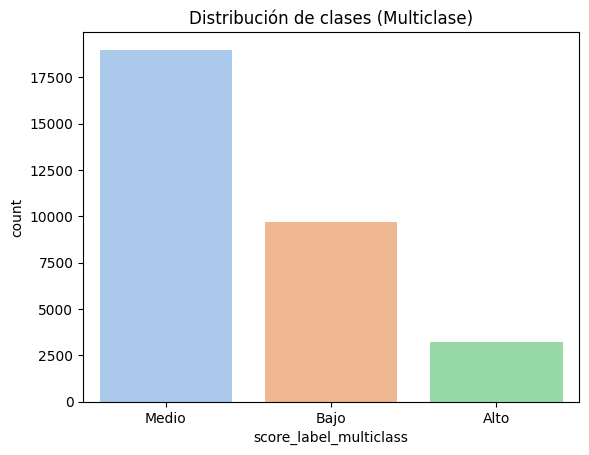

In [ ]:
# Visualizar distribución
sns.countplot(x="score_label_multiclass", data=df, palette="pastel")
plt.title("Distribución de clases (Multiclase)")
plt.show()

### División de datos

La variable objetivo será `score_label_multiclass` y excluiremos `contribution_score` y otras variables no útiles.

In [ ]:
# Copia del dataset base
df_clf = df.copy()

# Definición de variable objetivo (etiquetas multiclase)
y_clf = df_clf["score_label_multiclass"]

# Eliminamos variables que no deben usarse como predictoras
columnas_excluir = [
    "score_label_multiclass",  # variable objetivo
    "contribution_score",      # la estamos clasificando, así que no se usa como input
    "project_id", "employee_id", "assignment_id"  # identificadores
]

X_clf = df_clf.drop(columns=columnas_excluir)


### Identificación de variables categóricas y numéricas

Esto para aplicar diferentes transformaciones

In [ ]:
# Separar columnas categóricas y numéricas
cat_cols = X_clf.select_dtypes(include="object").columns.tolist()
num_cols = X_clf.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Variables categóricas:", cat_cols)
print("Variables numéricas:", num_cols)


Variables categóricas: ['assigned_role', 'role', 'experience_level', 'skills', 'availability', 'category', 'start_date', 'end_date', 'required_skills']
Variables numéricas: ['experience_years', 'project_duration', 'complexity', 'skill_match_score', 'role_match', 'experience_level_encoded', 'category_Finanzas', 'category_Operaciones', 'category_Recursos Humanos', 'category_Tecnología', 'category_Ventas', 'availability_Disponible', 'availability_No disponible', 'assigned_role_Accountant I', 'assigned_role_Administrative Assistant', 'assigned_role_Area Sales Manager', 'assigned_role_BI Developer', 'assigned_role_BI Director', 'assigned_role_CIO', 'assigned_role_Data Analyst', 'assigned_role_Data Analyst ', 'assigned_role_Data Architect', 'assigned_role_Database Administrator', 'assigned_role_Director of Operations', 'assigned_role_Director of Sales', 'assigned_role_Enterprise Architect', 'assigned_role_IT Director', 'assigned_role_IT Manager - DB', 'assigned_role_IT Manager - Infra', 'ass

### Codificación y escalamiento

In [ ]:
# Codificador para variables categóricas
cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Escalador para variables numéricas
num_transformer = StandardScaler()

# ColumnTransformer que aplica los pasos a las columnas adecuadas
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols)
    ]
)

# Crear un pipeline de solo preprocesamiento (sin modelo aún)
pipeline_preprocessing = Pipeline(steps=[
    ("preprocessor", preprocessor)
])

# Aplicar transformaciones a X
X_clf_processed = pipeline_preprocessing.fit_transform(X_clf)

# Confirmar forma de salida
print("Forma final de X (tras procesamiento):", X_clf_processed.shape)


Forma final de X (tras procesamiento): (31864, 4406)


### Entrenamiento, predicción y evaluación


 Modelo: baseline_clf_mf
              precision    recall  f1-score   support

        Alto      0.000     0.000     0.000       639
        Bajo      0.000     0.000     0.000      1936
       Medio      0.596     1.000     0.747      3798

    accuracy                          0.596      6373
   macro avg      0.199     0.333     0.249      6373
weighted avg      0.355     0.596     0.445      6373



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


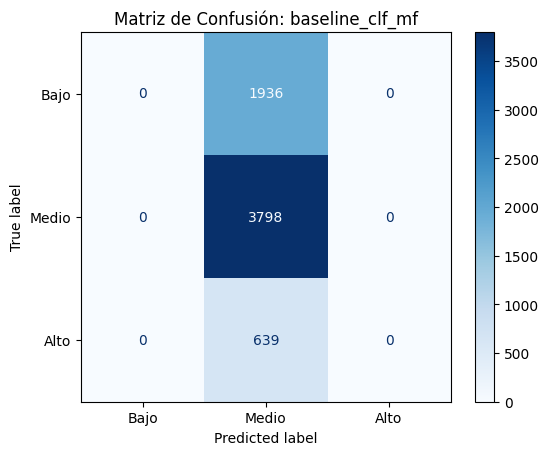


 Modelo: LogisticRegression
              precision    recall  f1-score   support

        Alto      0.315     0.709     0.436       639
        Bajo      0.656     0.606     0.630      1936
       Medio      0.707     0.586     0.641      3798

    accuracy                          0.605      6373
   macro avg      0.560     0.634     0.569      6373
weighted avg      0.652     0.605     0.617      6373



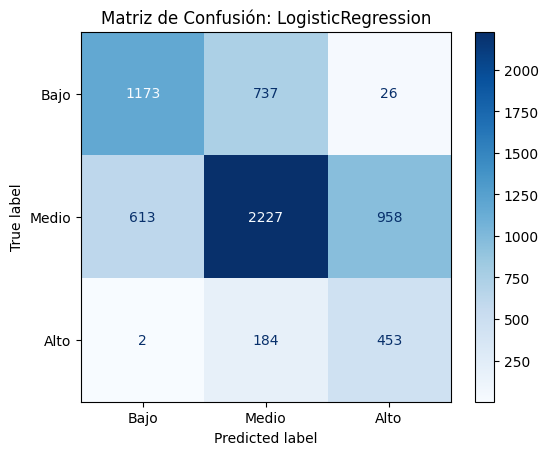


 Modelo: RandomForestClassifier
              precision    recall  f1-score   support

        Alto      0.413     0.111     0.175       639
        Bajo      0.917     0.508     0.654      1936
       Medio      0.703     0.950     0.808      3798

    accuracy                          0.732      6373
   macro avg      0.678     0.523     0.546      6373
weighted avg      0.739     0.732     0.698      6373



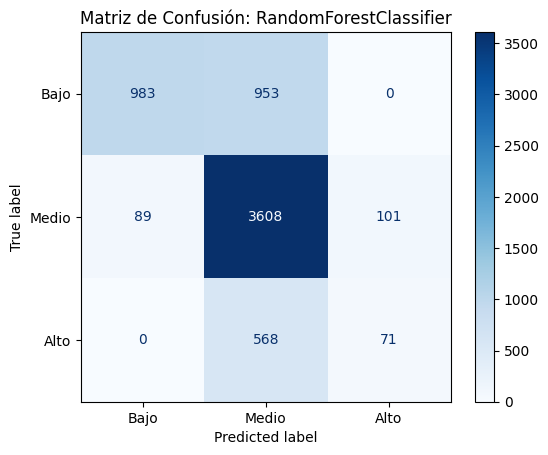


 Modelo: XGBClassifier


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:48:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

        Alto      0.400     0.013     0.024       639
        Bajo      0.993     0.489     0.655      1936
       Medio      0.700     0.995     0.822      3798

    accuracy                          0.743      6373
   macro avg      0.697     0.499     0.500      6373
weighted avg      0.759     0.743     0.691      6373



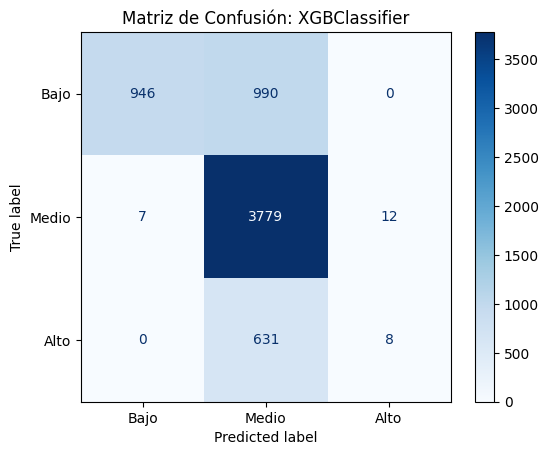

In [ ]:
# División del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(
    X_clf_processed, y_clf, test_size=0.2, stratify=y_clf, random_state=42
)

# Codificar etiquetas como números para XGBoost
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Modelos baseline
modelos = {
    "baseline_clf_mf": DummyClassifier(strategy="most_frequent", random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
    "XGBClassifier": XGBClassifier(n_estimators=100, eval_metric="mlogloss", use_label_encoder=False)
}

# Entrenamiento y evaluación
for nombre, modelo in modelos.items():
    print(f"\n Modelo: {nombre}")

    if nombre == "XGBClassifier":
        modelo.fit(X_train, y_train_enc)
        y_pred_enc = modelo.predict(X_test)
        y_pred = le.inverse_transform(y_pred_enc)
    else:
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

    print(classification_report(y_test, y_pred, digits=3))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=["Bajo", "Medio", "Alto"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bajo", "Medio", "Alto"])
    disp.plot(cmap='Blues')
    plt.title(f"Matriz de Confusión: {nombre}")
    plt.show()

Durante la evaluación de los modelos multiclase (Logistic Regression, Random Forest, y XGBoost) utilizando las variables enriquecidas y depuradas, se observaron mejoras importantes en el desempeño general comparado con los primeros ejercicios. Particularmente, las clases "Bajo" y "Medio" fueron identificadas con buena precisión y recall en los tres modelos, mostrando que los datos contienen patrones informativos útiles para diferenciar estos niveles de contribución.

Sin embargo, persiste un desafío relevante: la clase "Alto" sigue siendo la más difícil de predecir de forma consistente. Aunque modelos como Logistic Regression logran un recall elevado para esta clase, su precisión es baja, indicando un alto número de falsos positivos. Por otro lado, modelos más complejos como Random Forest y XGBoost tienden a sobreajustarse a la clase "Media", lo que resulta en una baja sensibilidad hacia los perfiles verdaderamente altos.

Este comportamiento sugiere que los casos con alto desempeño (contribution_score ≥ 80) son menos representativos, más complejos o menos diferenciados en términos de las variables disponibles. Esto afecta directamente al objetivo del proyecto, que es identificar de manera anticipada a los candidatos con mayor potencial de contribución.

In [ ]:
save_models(modelos, "modelos/Clasificacion")

Guardado: modelos/Clasificacion/baseline_clf_mf.joblib
Guardado: modelos/Clasificacion/LogisticRegression.joblib
Guardado: modelos/Clasificacion/RandomForestClassifier.joblib
Guardado: modelos/Clasificacion/XGBClassifier.joblib


## 3. Clasificación binaria: Alto vs No Alto


Optamos por reformular el problema como una tarea de clasificación binaria, donde se busca determinar si un colaborador es "Alto" (≥70 de score) o "No Alto" (<70).

Es importante mencionar que decidimos relajar la definición de "Alto" y "No Alto".

Esta decisión tiene los siguientes fundamentos:

* Permite al modelo enfocarse en detectar patrones asociados específicamente a la clase de mayor interés.
* Reduce el ruido causado por clases intermedias (como "Medio") que pueden solapar características con "Alto".
* Mejora la interpretabilidad del modelo en decisiones clave (¿es este candidato de alto rendimiento?).


Notamos que existe un desbalanceo severo entre la clases. Dicho esto, aplicaremos la técnica SMOTE para sobremuestrar la clase minoritaria Alto

### Crear variable binaria objetivo



In [ ]:
# Cargar dataset
df = pd.read_csv("dataset_modelo_baseline.csv")

# Crear etiqueta binaria: 1 si contribution_score >= 70
df["bin_class"] = (df["contribution_score"] >= 70).astype(int)
df["bin_class_label"] = df["bin_class"].map({1: "Alto", 0: "No Alto"})


### Definición de variables predictoras y objetivo

In [ ]:
# Columnas a excluir
cols_excluir = ["contribution_score", "bin_class", "bin_class_label", "project_id", "employee_id", "assignment_id"]

# Variables predictoras y objetivo
X_bin = df.drop(columns=cols_excluir, errors="ignore")
y_bin = df["bin_class"]

# Separar train-test
X_train, X_test, y_train, y_test = train_test_split(
    X_bin, y_bin, test_size=0.2, stratify=y_bin, random_state=42
)


### Preprocesamiento

In [ ]:
# Definir columnas por tipo
cat_features = ["role", "assigned_role", "category"]
minmax_features = ["experience_level_encoded", "skill_match_score", "role_match"]
std_features = ["experience_years", "project_duration", "n_required_skills"]

# Preprocesador con ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ("minmax", MinMaxScaler(), minmax_features),
    ("std", StandardScaler(), std_features)
])


### Transformar y balancear con SMOTE

In [ ]:
# Aplicar transformaciones
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)


### Entrenamiento, predicción y evaluación

In [ ]:
# Modelos a evaluar
modelos_binarios = {
    "baseline_bin_mf": DummyClassifier(strategy="most_frequent", random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBClassifier": XGBClassifier(n_estimators=100, eval_metric='logloss', use_label_encoder=False)
}


 Modelo: baseline_bin_mf
              precision    recall  f1-score   support

     No Alto       0.48      1.00      0.65      3070
        Alto       0.00      0.00      0.00      3303

    accuracy                           0.48      6373
   macro avg       0.24      0.50      0.33      6373
weighted avg       0.23      0.48      0.31      6373



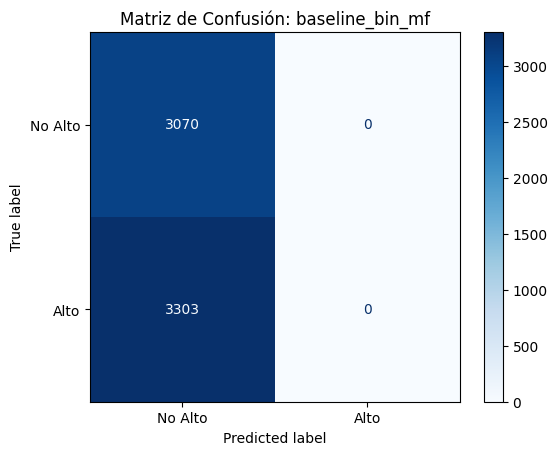


 Modelo: LogisticRegression
              precision    recall  f1-score   support

     No Alto       0.51      0.56      0.53      3070
        Alto       0.55      0.50      0.52      3303

    accuracy                           0.53      6373
   macro avg       0.53      0.53      0.53      6373
weighted avg       0.53      0.53      0.53      6373



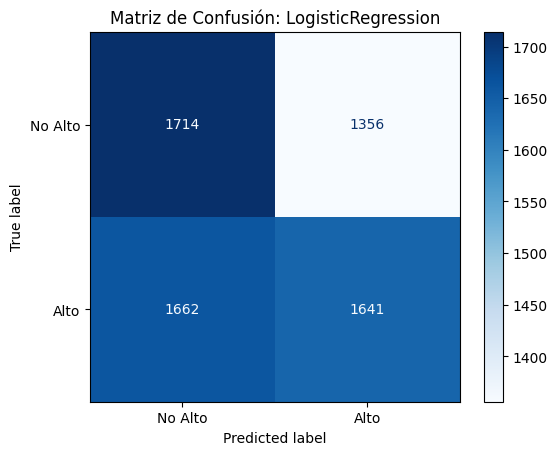


 Modelo: RandomForestClassifier
              precision    recall  f1-score   support

     No Alto       0.55      0.55      0.55      3070
        Alto       0.58      0.59      0.59      3303

    accuracy                           0.57      6373
   macro avg       0.57      0.57      0.57      6373
weighted avg       0.57      0.57      0.57      6373



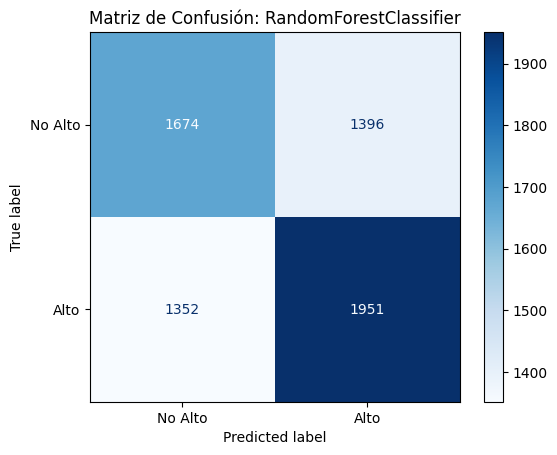


 Modelo: XGBClassifier


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:49:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

     No Alto       0.63      0.64      0.64      3070
        Alto       0.66      0.65      0.66      3303

    accuracy                           0.65      6373
   macro avg       0.65      0.65      0.65      6373
weighted avg       0.65      0.65      0.65      6373



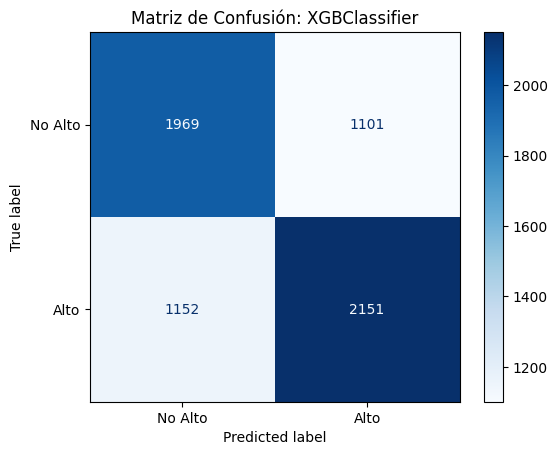

In [ ]:
for nombre, modelo in modelos_binarios.items():
    print(f"\n Modelo: {nombre}")

    modelo.fit(X_train_resampled, y_train_resampled)
    y_pred = modelo.predict(X_test_transformed)

    print(classification_report(y_test, y_pred, target_names=["No Alto", "Alto"], zero_division=0))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Alto", "Alto"])
    disp.plot(cmap='Blues')
    plt.title(f"Matriz de Confusión: {nombre}")
    plt.show()


In [ ]:
save_models(modelos, "modelos/ClasificacionBinaria")

Guardado: modelos/ClasificacionBinaria/baseline_clf_mf.joblib
Guardado: modelos/ClasificacionBinaria/LogisticRegression.joblib
Guardado: modelos/ClasificacionBinaria/RandomForestClassifier.joblib
Guardado: modelos/ClasificacionBinaria/XGBClassifier.joblib


In [ ]:
!zip -r modelos.zip modelos/

  adding: modelos/ (stored 0%)
  adding: modelos/ClasificacionBinaria/ (stored 0%)
  adding: modelos/ClasificacionBinaria/LogisticRegression.joblib (deflated 6%)
  adding: modelos/ClasificacionBinaria/XGBClassifier.joblib (deflated 72%)
  adding: modelos/ClasificacionBinaria/baseline_clf_mf.joblib (deflated 34%)
  adding: modelos/ClasificacionBinaria/RandomForestClassifier.joblib (deflated 79%)
  adding: modelos/Regresiones/ (stored 0%)
  adding: modelos/Regresiones/baseline_reg_mean.joblib (deflated 39%)
  adding: modelos/Regresiones/LinearRegression.joblib (deflated 31%)
  adding: modelos/Regresiones/RandomForestRegressor.joblib (deflated 82%)
  adding: modelos/Regresiones/XGBRegressor.joblib (deflated 72%)
  adding: modelos/Clasificacion/ (stored 0%)
  adding: modelos/Clasificacion/LogisticRegression.joblib (deflated 6%)
  adding: modelos/Clasificacion/XGBClassifier.joblib (deflated 72%)
  adding: modelos/Clasificacion/baseline_clf_mf.joblib (deflated 34%)
  adding: modelos/Clasific